In [13]:
import argparse
import os
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):

    box_scores = box_confidence * box_class_probs

    box_classes = tf.math.argmax(box_scores, -1)
    box_class_scores = tf.math.reduce_max(box_scores,-1)

    filtering_mask = box_class_scores >= threshold
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [3]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')

    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [4]:
def yolo_boxes_to_corners(box_xy, box_wh):
    
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],
        box_mins[..., 0:1],
        box_maxes[..., 1:2],
        box_maxes[..., 0:1]
    ])


In [5]:
from tensorflow.keras import backend as K

def scale_boxes(boxes, image_shape):

    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    
    return boxes

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):

    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    boxes = scale_boxes(boxes, image_shape)
    
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes , iou_threshold)
    
    return scores, boxes, classes

In [7]:
anchors = np.array([[0.57273 , 0.677385],
       [1.87446 , 2.06253 ],
       [3.33843 , 5.47434 ],
       [7.88282 , 3.52778 ],
       [9.77052 , 9.16828 ]])

class_names = ['person','bicycle','car','motorbike','aeroplane','bus','train','truck','boat','traffic light','fire hydrant',
'stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe','backpack',
'umbrella','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove',
               'skateboard','surfboard','tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana',
               'apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa','pottedplant',
               'bed','diningtable','toilet','tvmonitor','laptop','mouse','remote','keyboard','cell phone','microwave','oven',
               'toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush']

model_image_size = (608, 608)

In [8]:
yolo_model = load_model("model/",compile=False)

C:\Users\HOME\Desktop\collegeML\od\TFODCourse\tfod\lib\site-packages\keras\layers\core\lambda_layer.py:297: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [9]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [17]:
def yolo_head(feats, anchors, num_classes):

    num_anchors = len(anchors)

    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    conv_dims = K.shape(feats)[1:3]

    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

In [18]:
import colorsys
def get_colors_for_classes(num_classes):
    
    if (hasattr(get_colors_for_classes, "colors") and len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)
    random.shuffle(colors)
    random.seed(None)
    get_colors_for_classes.colors = colors
    return colors

In [19]:
import imghdr
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)
    return image, image_data

In [37]:
def draw_boxes(image, boxes, box_classes, class_names, scores=None):

#     font = ImageFont.truetype(
#         font='font/FiraMono-Medium.otf',
#         size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    font = ImageFont.truetype("arial.ttf", 28, encoding="unic")
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label,font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0),font=font)
        del draw

    return np.array(image)


In [38]:
def predict(image_file):

    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))

    colors = get_colors_for_classes(len(class_names))

    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    
    image.save(os.path.join("out", image_file), quality=100)

    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 1 boxes for images/dog.jpg
dog 0.76 (471, 151) (1820, 1828)


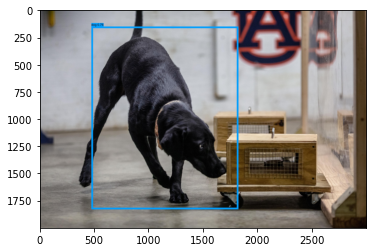

In [46]:
out_scores, out_boxes, out_classes = predict("dog.jpg")